In [6]:
import pandas as pd
import numpy as np
import os 
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#TEST_IMAGE_DIR = "./dog-breed-identification/test/"
TRAIN_IMAGE_DIR = "../dog-breed-identification/train/"
LABELS = '../dog-breed-identification/labels.csv'

data = pd.read_csv(LABELS)

In [7]:
#Data from the csv only contans the ids of the photos and not the photos itself
#Iterate through the data and check whether the photo is in test or train
#Then fetch it and store it in its proper variable
import tensorflow as tf
from os.path import join
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def load_and_preprocess_images(image_dir, image_ids, target_size=(224, 224)):
    image_data = []
    for img_id in image_ids:
        img_path = join(image_dir, img_id + ".jpg")
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        preprocessed_img = preprocess_input(img_array) #I dont flatten the image here
        image_data.append(preprocessed_img)
    return np.array(image_data)

# Get image IDs for train and test
train_image_ids = data['id'].values
labels = data['breed'].values
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

train_image_ids, unfinished_test_image_ids, train_labels, unfinished_test_labels = train_test_split(train_image_ids, encoded_labels, test_size=0.3, random_state=42, stratify=encoded_labels)

test_image_ids, val_image_ids, test_labels, val_labels = train_test_split(unfinished_test_image_ids, unfinished_test_labels, test_size=0.5, random_state=42, stratify=unfinished_test_labels)

train_images = load_and_preprocess_images(TRAIN_IMAGE_DIR, train_image_ids)
test_images = load_and_preprocess_images(TRAIN_IMAGE_DIR, test_image_ids)
val_images = load_and_preprocess_images(TRAIN_IMAGE_DIR, val_image_ids)

train_images = train_images / 250.0
test_images = test_images / 250.0
val_images = val_images / 250.0

In [9]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('../models/55Model.hdf5')

# Use the loaded model to make predictions
predictions = loaded_model.predict(test_images)

48/48 [==============================] - 10s 105ms/step


In [10]:
test_loss, test_acc = loaded_model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

48/48 - 3s - loss: 1.7114 - accuracy: 0.5545 - 3s/epoch - 60ms/step

Test accuracy: 0.5544683337211609


In [11]:
def test_model_by_index(index, top_n=1):
    
    # Get the image and actual encoded label at the given index
    image = test_images[index]
    actual_encoded_label = test_labels[index]
    
    # Find the class label text corresponding to the actual encoded label
    actual_label_text = label_encoder.classes_[actual_encoded_label]
    
    # Reshape the input image to match the expected input shape for the model
    input_image = np.expand_dims(image, axis=0)
    
    # Make a prediction using the model
    prediction = loaded_model.predict(input_image)
    
    # Get the indices of the top n predicted class probabilities
    top_n_indices = np.argsort(prediction[0])[-top_n:][::-1]
    
    # Get the predicted class labels and their probabilities
    predicted_labels = [label_encoder.classes_[idx] for idx in top_n_indices]
    predicted_probabilities = [prediction[0][idx] for idx in top_n_indices]
    
    # Display the image and the labels
    plt.imshow(image)
    plt.title(f"Actual: {actual_label_text}")
    plt.show()

    print(f"Top {top_n} predictions:")
    for label, probability in zip(predicted_labels, predicted_probabilities):
        print(f"{label}: {probability*100:.2f}%")

1/1 [==============================] - 0s 308ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


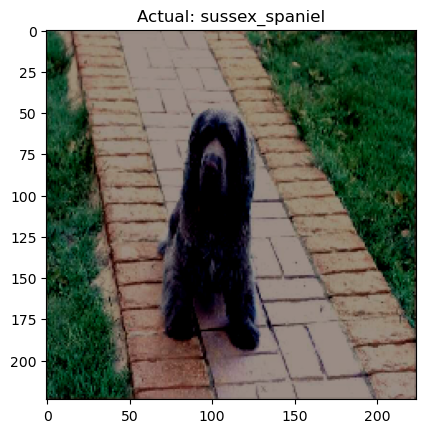

Top 5 predictions:
sussex_spaniel: 26.22%
irish_setter: 23.53%
bloodhound: 22.47%
cocker_spaniel: 9.30%
silky_terrier: 2.39%


In [12]:
#Here, you can pass in an index, from 0 to 1499 as there are 1500 test images
#The second paramater is how many top N guesses you want

test_model_by_index(25, 5)

In [ ]:
def print_all_test_labels():
    for index, actual_encoded_label in enumerate(test_labels):
        actual_label_text = label_encoder.classes_[actual_encoded_label]
        print(f"Index {index}: {actual_label_text}")
print_all_test_labels()